In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import re
import string
import contractions

from nltk.corpus import stopwords
from textblob import TextBlob
import spacy

from helpers import *

# Part 1
## EDA, additional features

In [2]:
aita = pd.read_csv('data/aita_clean.csv')

In [3]:
print(f'There are {aita.shape[0]} posts before dropping NA')
aita.dropna(inplace=True)
print(f'There are {aita.shape[0]} posts after dropping NA')

There are 97628 posts before dropping NA
There are 97541 posts after dropping NA


not the asshole     59069
asshole             20921
no assholes here    12001
everyone sucks       5550
Name: verdict, dtype: int64

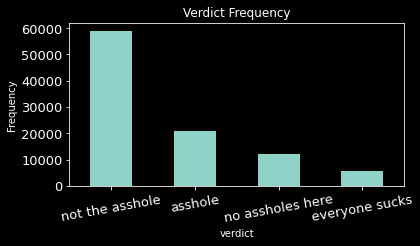

In [4]:
aita.value_counts('verdict').plot(kind='bar', figsize=(6, 3), ylabel='Frequency',title='Verdict Frequency', fontsize=13, rot=10);
plt.savefig('image/verdict_bar.png')
aita.verdict.value_counts()

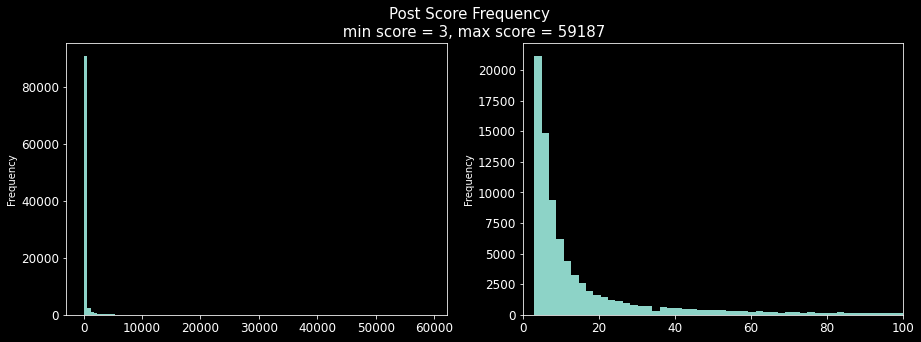

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
aita.score.plot(kind='hist', bins=100, ax=ax[0], fontsize=12);
aita.score[aita.score <= 100].plot(kind='hist', bins=50, ax=ax[1], xlabel='Post Score', xlim=(0,100),fontsize=12)
plt.ylabel('Frequency')
plt.suptitle(f'Post Score Frequency \n min score = {aita.score.min()}, max score = {aita.score.max()}', fontsize=15);
plt.savefig('image/post_freq_hist.png')

## Clean Body and Title little bit
take out line break, links, words like "aita" "wibta"

and expand contractions 

In [6]:
aita['body_lil_clean'] = aita['body'].apply(lambda x : clean_lil_bit(x))
aita['title_lil_clean'] = aita['title'].apply(lambda x : clean_lil_bit(x))

## Get OP's age and sex data from post body

In [7]:
def poster_age_sex(text):
    find = re.findall('(?:i|i am a|my|i.?m a?)\s?\(?\[?([0-9]{2}) ?([mf][t]?[mf]?)\)?\]?', text)
    if find:
        age = int(find[0][0])
        sex = find[0][1]
        if sex == 'mf':
            sex = 'm'
        elif sex == 'fm':
            sex = 'f'
        return age, sex
    else: 
        return 0,'NA'

In [8]:
aita['age'] = aita['body_lil_clean'].apply(lambda x : poster_age_sex(x)[0])
aita['sex'] = aita['body_lil_clean'].apply(lambda x : poster_age_sex(x)[1])

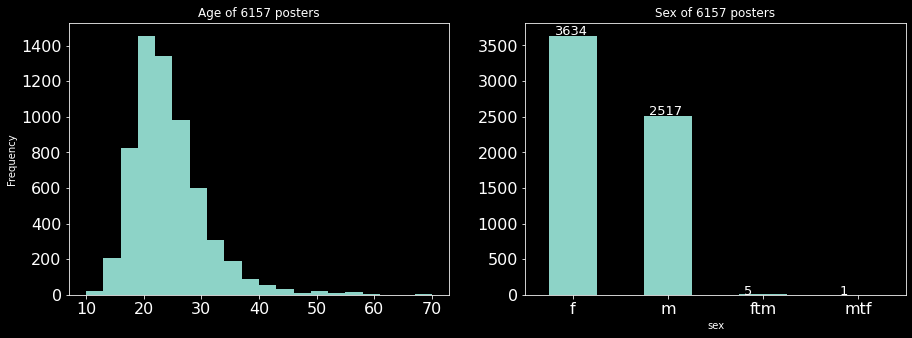

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
age = aita['age'][aita.age != 0]
sex = aita['sex'][aita.sex != 'NA']
ax[0] = age.plot(kind='hist', bins=20, ax=ax[0], title=f'Age of {len(age)} posters', xlabel='Age', fontsize=16)
ax[1] = sex.value_counts().plot(kind='bar', ax=ax[1], title=f'Sex of {len(sex)} posters', xlabel='sex', fontsize=16, rot=0)
for p in ax[1].patches:
    ax[1].annotate(str(p.get_height()), (p.get_x()+.05, p.get_height() * 1.005), fontsize=13)

plt.savefig('image/age_sex.png')

## Adding sentiment columns to aita table

In [295]:
aita['body_polarity'] = aita['body_lil_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)
aita['body_subjectivity'] = aita['body_lil_clean'].apply(lambda x : TextBlob(x).sentiment.subjectivity)
# aita['title_polarity'] = aita['title_lil_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)
# aita['title_subjectivity'] = aita['title_lil_clean'].apply(lambda x : TextBlob(x).sentiment.subjectivity)

In [296]:
aita[['body_polarity','body_subjectivity','is_asshole']].groupby('is_asshole').agg({'body_polarity': ['min','mean','max'],'body_subjectivity':['min','mean','max']})

body_polarity                   body_subjectivity               
                     min      mean     max               min      mean  max
is_asshole                                                                 
0                 -0.825  0.040840  0.8625               0.0  0.477543  1.0
1                 -1.000  0.042177  0.7000               0.0  0.480755  1.0

In [2]:
# aita[['title_polarity','title_subjectivity','is_asshole']].groupby('is_asshole').agg({'title_polarity': ['min','mean','max'],'title_subjectivity':['min','mean','max']})

In [298]:
aita_save1 = aita[['body_lil_clean','title_lil_clean','age','sex','body_polarity','body_subjectivity','title_polarity','title_subjectivity','verdict','is_asshole']]
aita_save1.to_csv('data/aita_save1.csv', index=False)

## cleaning posts

In [303]:
aita_1 = pd.read_csv('data/aita_save1.csv')

In [306]:
aita['body_clean'] = aita.body_lil_clean.apply(lambda x : remove_punc(x))
aita['title_clean'] = aita.title_lil_clean.apply(lambda x : remove_punc(x))

In [307]:
aita_2 = aita[['body_clean','title_clean','age','sex','body_polarity','body_subjectivity','title_polarity','title_subjectivity','is_asshole','verdict']]
aita_2.to_csv('data/aita_save2.csv', index=False)